In [1]:
from scipy import linalg as la
from scipy.sparse import diags
import numpy as np
import math
from scipy.integrate import quad
from scipy import stats
from matplotlib import pyplot as plt
from scipy.integrate import nquad

In [2]:
class GaussianQuadrature:
    """Class for integrating functions on arbitrary intervals using Gaussian
    quadrature with the Legendre polynomials or the Chebyshev polynomials.
    """
    def __init__(self, n, polytype="legendre"):
        """Calculate and store the n points and weights corresponding to the
        specified class of orthogonal polynomial (Problem 3). Also store the
        inverse weight function w(x)^{-1} = 1 / w(x).

        Parameters:
            n (int): Number of points and weights to use in the quadrature.
            polytype (string): The class of orthogonal polynomials to use in
                the quadrature. Must be either 'legendre' or 'chebyshev'.

        Raises:
            ValueError: if polytype is not 'legendre' or 'chebyshev'.
        """
        self.n = n
        if polytype not in ['legendre', 'chebyshev', 'Chebyshev', 'Legendre']:
            raise ValueError('unknown polynomial type')
        self.polytype = polytype
        self.jacobi = None

        #save weight function
        if self.polytype == 'legendre':
            self.f = lambda x: 1
            self.measure = 2
        else:
            self.f = lambda x: 1/np.sqrt(1-x**2)
            self.measure = np.pi

        self.xi, self.weights = self.points_weights(n)
        #define reciprocal
        self.reciprocal = lambda x: 1/self.f(x)

    def points_weights(self, n):
        """Calculate the n points and weights for Gaussian quadrature.

        Parameters:
            n (int): The number of desired points and weights.

        Returns:
            points ((n,) ndarray): The sampling points for the quadrature.
            weights ((n,) ndarray): The weights corresponding to the points.
        """
        if self.polytype == 'legendre':
            alpha = lambda k: 0
            beta = lambda k: k**2/(4*k**2-1)
        else:
            alpha = lambda k: 0
            beta = lambda k: 1/2 if k ==1 else 1/4

        diagonals = np.array([[math.sqrt(beta(i)) for i in range(1, n)], [alpha(i) for i in range(n)], [math.sqrt(beta(i)) for i in range(1, n)]])
        self.jacobi = diags(diagonals,[-1,0,1]).toarray()
        data = la.eig(self.jacobi)
        self.xi = data[0]
        eigvectors = data[1]
        self.weights = np.ones(n)
        for i in range(n):
            self.weights[i] = self.measure * eigvectors[0][i]**2
        return np.real(self.xi), np.real(self.weights)

    def basic(self, f):
        """Approximate the integral of a f on the interval [-1,1]."""
        g = lambda x: self.reciprocal(x) * f(x)
        return np.real(self.weights).T @ g(np.real(self.xi))

    def integrate(self, f, a, b):
        """Approximate the integral of a function on the interval [a,b].

        Parameters:
            f (function): Callable function to integrate.
            a (float): Lower bound of integration.
            b (float): Upper bound of integration.

        Returns:
            (float): Approximate value of the integral.
        """
        h = lambda x: f((b-a)/2 *x + (a+b)/2) 
        return (b-a)/2 * self.basic(h)

    def integrate2d(self, f, a1, b1, a2, b2):
        """Approximate the integral of the two-dimensional function f on
        the interval [a1,b1]x[a2,b2].

        Parameters:
            f (function): A function to integrate that takes two parameters.
            a1 (float): Lower bound of integration in the x-dimension.
            b1 (float): Upper bound of integration in the x-dimension.
            a2 (float): Lower bound of integration in the y-dimension.
            b2 (float): Upper bound of integration in the y-dimension.

        Returns:
            (float): Approximate value of the integral.
        """
        h = lambda x,y: f((b1-a1)/2*x + (b1+a1)/2, (b2-a2)/2*y + (b2+a2)/2)
        g = lambda x,y: h(x,y) * self.reciprocal(x) *self.reciprocal(y)
        return ((b1-a1)*(b2-a2))/4* np.sum([np.sum([self.weights[i]*self.weights[j]*g(np.real(self.xi[i]), np.real(self.xi[j])) for j in range(self.n)]) for i in range(self.n)] )


In [5]:
def test2():
    obj = GaussianQuadrature(5,'legendre')
    print('legendre')
    print(obj.points_weights(5))
    obj = GaussianQuadrature(5,'chebyshev')
    print('cheby')
    print(obj.points_weights(5))

def test3():
    f = lambda x: 1 / np.sqrt(1 - x**2)
    g = lambda x: x**2
    temp = quad(g, -1, 1)[0]
    print(temp)
    obj = GaussianQuadrature(20,'legendre')
    #obj.points_weights(100)
    temp2 = obj.basic(g)
    print(temp2)

    obj = GaussianQuadrature(5,'Chebyshev')
    obj.points_weights(5)
    temp3 = obj.basic(f)
    print(temp3)

def test4():
    f = lambda x: 1 / np.sqrt(1 - x**2)
    temp = quad(f, 0, 1)[0]
    print(temp)
    obj = GaussianQuadrature(100,'legendre')
    obj.points_weights(100)
    temp2 = obj.integrate(f, 0,1)
    print(temp2)

    obj = GaussianQuadrature(5,'Chebyshev')
    obj.points_weights(5)
    temp3 = obj.integrate(f, 0,1)
    print(temp3)

def test6():
    f = lambda x, y: np.sin(x) + np.cos(y)
    print(nquad(f, [[-10, 10], [-1, 1]])[0])

    obj = GaussianQuadrature(100,'legendre')
    obj.points_weights(100)
    temp2 = obj.integrate2d(f, -10,10, -1,1)
    print(temp2)

    obj = GaussianQuadrature(5,'Chebyshev')
    obj.points_weights(5)
    temp3 = obj.integrate2d(f, -10,10, -1,1)
    print(temp3)

In [6]:
test2()

legendre
(array([-9.06179846e-01, -5.38469310e-01, -1.77878879e-16,  9.06179846e-01,
        5.38469310e-01]), array([0.23692689, 0.47862867, 0.56888889, 0.23692689, 0.47862867]))
cheby
(array([-9.51056516e-01, -5.87785252e-01,  1.46034345e-17,  9.51056516e-01,
        5.87785252e-01]), array([0.62831853, 0.62831853, 0.62831853, 0.62831853, 0.62831853]))


In [7]:
test3()

0.6666666666666666
0.666666666666669
3.141592653589793


In [8]:
test4()

1.570796326794894
1.5646702555594798
1.579121088814481


In [9]:
test6()

33.658839392315855
33.658839392315755
34.56342495655723


In [19]:
def PlotErrors():
    """Use scipy.stats to calculate the "exact" value F of the integral of
    f(x) = (1/sqrt(2 pi))e^((-x^2)/2) from -3 to 2. Then repeat the following
    experiment for n = 5, 10, 15, ..., 50.
        1. Use the GaussianQuadrature class with the Legendre polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
        2. Use the GaussianQuadrature class with the Chebyshev polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
    Plot the errors against the number of points and weights n, using a log
    scale for the y-axis. Finally, plot a horizontal line showing the error of
    scipy.integrate.quad() (which doesn’t depend on n).
    """
    f = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
    n_list = [5*i for i in range(1,11)]

    exact = stats.norm.cdf(2) - stats.norm.cdf(-3)
    temp = quad(f, -3, 2)[0]
    quad_list = [abs(exact - temp) for i in range(10)]

    approx1 = []
    approx2 = []
    for n in n_list:
        obj = GaussianQuadrature(n,'legendre')
        obj.points_weights(n)
        approx1.append(abs(obj.integrate(f,-3,2) - exact))

        obj = GaussianQuadrature(n,'chebyshev')
        obj.points_weights(n)
        approx2.append(abs(obj.integrate(f,-3,2) - exact))

    plt.yscale('log')
    plt.plot(n_list,approx1, label='legendre')
    plt.plot(n_list,approx2, label='chebyshev')
    plt.plot(n_list,quad_list, label='Scipy quad')
    plt.xlabel('N')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

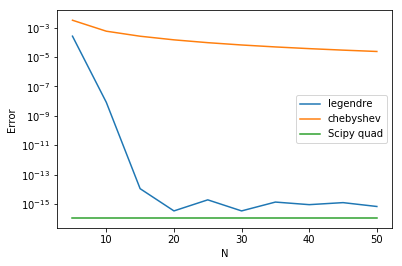

In [20]:
PlotErrors()